In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.image as img
import plotly.graph_objects as go
import pathlib
import os
import copy
import random
import time
from random import randint
from PIL import Image
from IPython.display import HTML
from plotly.subplots import make_subplots
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import Dataset , DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import Adam
from torch.autograd import Variable
import cv2
import os
import glob



In [2]:
DataPath = 'c:/workspace/Data/Rice_Image_Dataset/'
dic = {'Arborio': 0, 'basmati': 1, 'Ipsala': 2, 'Jasmine': 3, 'Karacadag': 4}

device = "cuda"
fname=[]
limit =500
path=[]
for name in glob.glob(DataPath+"*[!.txt]"): 
    temp=0
    for filename in os.listdir(name):   
        if temp >= limit:
            break
        fname.append(filename)
        path.append(name)
        temp = temp+1

fname[0], path[0]

('Arborio (1).jpg', 'c:/workspace/Data/Rice_Image_Dataset\\Arborio')

In [6]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(100),
    transforms.ToTensor(),
])

In [7]:
class RiceData(Dataset):
    def __init__(self, filename , root):
        self.filename = filename
        self.root = root

    def __getitem__(self, index):
        path = self.root[index]
        direct = self.filename[index].split(' ')[0]
        filename = self.filename[index]
        label = dic[direct]
        img = cv2.imread(f"{path}/{filename}")
        img = transform(img)
        return img, label
    
    def __len__(self):
        return len(self.filename)
    
train_ds = RiceData(fname, root=path)
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)

dataiter = iter(train_dl)
data = next(dataiter)
img, labels = data
print(img, labels)


tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
        

In [8]:
test_split = 0.2  
shuffle_dataset = True
random_seed = 1234
dataset_size = len(train_ds)
indices = list(range(dataset_size))
split = int(np.floor(test_split * dataset_size))
if shuffle_dataset:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)
train_loader = DataLoader(train_ds, batch_size=1, sampler=train_sampler)
test_loader = DataLoader(train_ds, batch_size=1, sampler=test_sampler)
dataiter = train_loader.__iter__()
data = dataiter.__next__()
img, labels = data

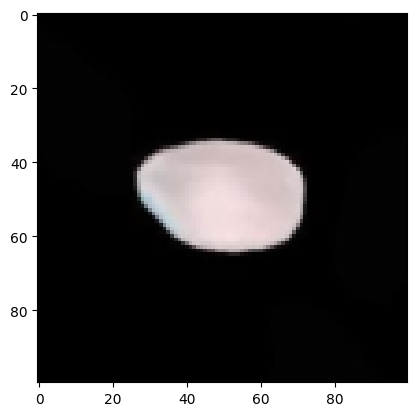

In [9]:
img = img[0].swapaxes(0, 1)    # swapaxes : 축 변경
img = img.swapaxes(1, 2)
plt.imshow(img)
plt.show()



In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 25 * 25, 128)   # Flatten()   1차원으로 만들어줌
        self.fc2 = nn.Linear(128, 5)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(-1, 32 * 25 * 25)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x



In [11]:
model = CNN()
optimizer = optim.Adam(model.parameters())
for epoch in range(2):   # epoch을 두번만.
    for i, (images, labels) in enumerate(train_loader):    # enumerate: 제너레이터
        optimizer.zero_grad()
        output = model(images)
      
        loss = nn.functional.cross_entropy(output, labels)
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, 10, i+1, len(train_loader), loss.item()))


Epoch [1/10], Step [1/2000], Loss: 1.5899
Epoch [1/10], Step [101/2000], Loss: 0.6134
Epoch [1/10], Step [201/2000], Loss: 0.5305
Epoch [1/10], Step [301/2000], Loss: 0.0011
Epoch [1/10], Step [401/2000], Loss: 0.0182
Epoch [1/10], Step [501/2000], Loss: 1.3008
Epoch [1/10], Step [601/2000], Loss: 0.0516
Epoch [1/10], Step [701/2000], Loss: 0.0012
Epoch [1/10], Step [801/2000], Loss: 0.0132
Epoch [1/10], Step [901/2000], Loss: 0.0071
Epoch [1/10], Step [1001/2000], Loss: 0.0022
Epoch [1/10], Step [1101/2000], Loss: 0.0044
Epoch [1/10], Step [1201/2000], Loss: 0.0258
Epoch [1/10], Step [1301/2000], Loss: 0.0048
Epoch [1/10], Step [1401/2000], Loss: 0.0182
Epoch [1/10], Step [1501/2000], Loss: 0.0637
Epoch [1/10], Step [1601/2000], Loss: 0.0611
Epoch [1/10], Step [1701/2000], Loss: 0.3263
Epoch [1/10], Step [1801/2000], Loss: 0.0066
Epoch [1/10], Step [1901/2000], Loss: 5.3311
Epoch [2/10], Step [1/2000], Loss: 0.5453
Epoch [2/10], Step [101/2000], Loss: 0.0001
Epoch [2/10], Step [201/20

In [12]:
correct = 0
total = 0
with torch.no_grad():
    try:
        for images , labels in test_loader:
            #print(labels.numpy())
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    except:
        pass
        
print (correct/total)



0.9647058823529412
